In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from words import *

# Get data

In [4]:
MAX_LEN = 15

In [5]:
languages = sorted(['en', 'de', 'fr', 'it', 'sp'])
languages

['de', 'en', 'fr', 'it', 'sp']

In [6]:
filepaths = get_filepaths(*languages)
df = read_data(filepaths)
df = filter_data(df, min_len=4, max_len=MAX_LEN, min_freq=5)
df.language = df.language.str.slice(0, 2)

In [7]:
df.head()

,word,freq,language
37,wurde,1463,de
46,sich,1066,de
47,eine,1049,de
53,auch,662,de
55,nach,653,de


In [8]:
df.groupby('language').size()

language
de    3104
en    4613
fr    4079
it    4480
sp    4312
dtype: int64

### Remove duplicate words across languages

In [9]:
joined = df.merge(df, on=['word'])
joined = joined[joined.language_x != joined.language_y]
duplicate_words = list(set(joined.word))
print(duplicate_words)

['variable', 'server', 'observe', 'philosophie', 'cast', 'gold', 'magico', 'missions', 'colonies', 'test', 'allen', 'forma', 'campo', 'capitan', 'analyse', 'population', 'piste', 'navy', 'marzo', 'realmente', 'viii', 'entre', 'persona', 'teatro', 'communication', 'carte', 'arts', 'marcus', 'conference', 'francia', 'inspiration', 'dedico', 'jose', 'virginia', 'bruno', 'millions', 'incendio', 'complete', 'viene', 'apple', 'error', 'franchise', 'region', 'tiene', 'corporation', 'data', 'cooper', 'sector', 'albert', 'portrait', 'warner', 'camp', 'diverse', 'richard', 'avance', 'match', 'madre', 'destino', 'compagnie', 'precisamente', 'college', 'norme', 'finale', 'present', 'donald', 'with', 'parties', 'mobile', 'xiii', 'suicide', 'decide', 'francisco', 'fallen', 'genre', 'clients', 'prison', 'copia', 'software', 'federal', 'commercial', 'diametro', 'name', 'arco', 'instrument', 'nick', 'public', 'hall', 'artistica', 'superficie', 'jazz', 'continua', 'italien', 'natural', 'descriptions', '

In [10]:
df = df[~df.word.isin(duplicate_words)]

In [11]:
df.groupby('language').size()

language
de    2795
en    3606
fr    3159
it    3694
sp    3482
dtype: int64

### Remove duplicate words within languages

In [12]:
df = df.drop_duplicates('word')

In [13]:
assert len(df.word) == len(set(df.word))

In [14]:
df.groupby('language').size()

language
de    2623
en    3387
fr    2922
it    3483
sp    3199
dtype: int64

### Get validation indices

In [15]:
df = df.reset_index(drop=True)

In [16]:
train_idxs, val_idxs = train_test_split(df.index.tolist(), train_size=0.5, random_state=1)

/home/quentin/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Get letters as features

In [17]:
feats = extract_features(df)

In [18]:
feats.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,language
0,w,u,r,d,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,de
1,s,i,c,h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,de
2,e,i,n,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,de
3,a,u,c,h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,de
4,n,a,c,h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,de


# One-encoded features model

In [19]:
from fastai.structured import *
from fastai.column_data import *

### Dumify variables

In [20]:
def gen_dummy_cols():
    for i in range(MAX_LEN):
        for c_i in range(ord('a'), ord('z') + 1):
            c = chr(c_i)
            yield f'{i}_{c}'
        yield f'{i}_nan'

dummy_cols = list(gen_dummy_cols())

In [21]:
print(dummy_cols[:30])
print(dummy_cols[-30:])

['0_a', '0_b', '0_c', '0_d', '0_e', '0_f', '0_g', '0_h', '0_i', '0_j', '0_k', '0_l', '0_m', '0_n', '0_o', '0_p', '0_q', '0_r', '0_s', '0_t', '0_u', '0_v', '0_w', '0_x', '0_y', '0_z', '0_nan', '1_a', '1_b', '1_c']
['13_y', '13_z', '13_nan', '14_a', '14_b', '14_c', '14_d', '14_e', '14_f', '14_g', '14_h', '14_i', '14_j', '14_k', '14_l', '14_m', '14_n', '14_o', '14_p', '14_q', '14_r', '14_s', '14_t', '14_u', '14_v', '14_w', '14_x', '14_y', '14_z', '14_nan']


In [22]:
y = feats['language']
y_dummy = pd.get_dummies(y)
y_dummy = y_dummy.astype(np.float32).reset_index(drop=True)

In [23]:
feats_no_label = feats.drop('language', axis=1)

In [24]:
feats_dummy = pd.get_dummies(feats, dummy_na=True)
feats_dummy = feats_dummy.T.reindex(dummy_cols).T.fillna(0)
feats_dummy = feats_dummy.astype(np.float32).reset_index(drop=True)

In [25]:
feats_dummy.head()

,0_a,0_b,0_c,0_d,0_e,0_f,0_g,0_h,0_i,0_j,...,14_r,14_s,14_t,14_u,14_v,14_w,14_x,14_y,14_z,14_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
y_dummy.head()

,de,en,fr,it,sp
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


### Model

In [27]:
PATH = 'data/words/'
md = ColumnarModelData.from_data_frame(PATH, val_idxs, df=feats_dummy, y=y_dummy.values, cat_flds=[], bs=128,
                                       is_reg=False, is_multi=True)

In [28]:
learn = md.get_learner(emb_szs=[], n_cont=feats_dummy.shape[1], emb_drop=0, out_sz=len(languages),
                       szs=[500], drops=[0.3])

In [29]:
learn.lr_find()

epoch      trn_loss   val_loss                             
    0      0.772547   2.92324   



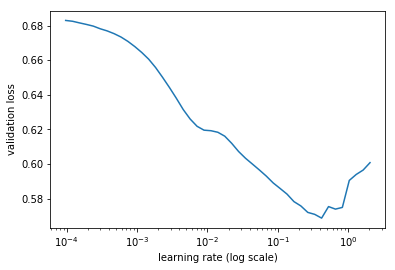

In [30]:
learn.sched.plot()

In [31]:
def accuracy(preds, targs):
    _, preds = torch.max(preds, dim=1)
    _, targs = torch.max(targs, dim=1)
    return (preds==targs).float().mean()

In [32]:
learn.fit(0.1, n_cycle=3, cycle_len=15, cycle_mult=2, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                   
    0      0.504026   0.447197   0.432561  
    1      0.44449    0.404675   0.529397                  
    2      0.406503   0.386851   0.54861                   
    3      0.375336   0.381556   0.564878                  
    4      0.344116   0.370899   0.586397                  
    5      0.310273   0.369328   0.602792                  
    6      0.282573   0.361243   0.623671                  
    7      0.252843   0.375061   0.61906                   
    8      0.229754   0.370397   0.639554                  
    9      0.20852    0.369099   0.655822                  
    10     0.188098   0.374926   0.658768                  
    11     0.175973   0.373572   0.660049                  
    12     0.166294   0.380286   0.660817                  
    13     0.161107   0.37994    0.662354                  
    14     0.155151   0.379998   0.663123                  
    15     0.234024   0.42781    0.596132              

[array([0.79822]), 0.6506980914563852]

### Predict and enrich validation dataset for analysis

In [33]:
df_val = df.iloc[val_idxs].reset_index(drop=True)

In [34]:
labels = np.argmax(y_dummy.iloc[val_idxs].values, axis=1)
df_val['language_id'] = labels

In [35]:
preds_dummy = learn.predict_array(x_cat=[0], x_cont=feats_dummy.iloc[val_idxs])
preds = np.argmax(preds_dummy, axis=1)
probas = np.max(preds_dummy, axis=1)
df_val['pred_id'] = preds
df_val['probas'] = probas

In [36]:
df_val['pred'] = df_val['pred_id'].map(dict(enumerate(languages)))

### Results analysis

In [37]:
# Most confident predictions
df_val.sort_values('probas', ascending=False).head(10)

,word,freq,language,language_id,pred_id,probas,pred
0,preparazione,14,it,3,3,1.0,it
6393,einfuhrung,19,de,0,0,1.0,de
1341,speaks,5,en,1,1,1.0,en
3253,satisfy,7,en,1,1,1.0,en
3254,jahrhunderts,71,de,0,0,1.0,de
3257,testimonio,6,sp,4,3,1.0,it
6404,concerning,8,en,1,0,1.0,de
1335,arrivato,10,it,3,3,1.0,it
3260,provoque,6,fr,2,2,1.0,fr
3261,frazione,11,it,3,3,1.0,it


In [38]:
# Least confident predictions
df_val.sort_values('probas').head(10)

,word,freq,language,language_id,pred_id,probas,pred
3416,zusammenarbeit,6,de,0,4,3.462990e-11,sp
743,riconoscimento,8,it,3,4,6.833682e-11,sp
298,esclusivamente,13,it,3,4,8.461777e-11,sp
3162,transformacion,6,sp,4,2,2.441605e-09,fr
7501,traditionnelles,6,fr,2,4,5.535431e-09,sp
6445,probabilmente,34,it,3,3,6.697310e-09,it
737,dreiigjahrigen,5,de,0,4,5.128665e-08,sp
5432,fonctionnement,13,fr,2,2,1.815283e-05,fr
2839,sperimentazione,5,it,3,3,2.487817e-05,it
1231,traditionellen,7,de,0,0,6.021503e-05,de


In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [40]:
cm = confusion_matrix(df_val['language'], df_val['pred'])

Confusion matrix, without normalization
[[ 972  160  106   59   40]
 [ 177 1056  255  105  129]
 [ 120  231  854  153  110]
 [  47   63  188 1156  273]
 [  52  102  153  204 1042]]


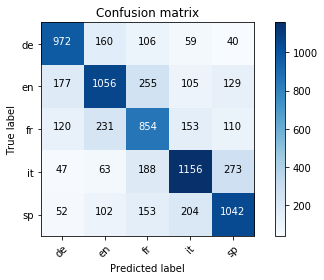

In [41]:
plot_confusion_matrix(cm, languages)

Normalized confusion matrix
[[0.727   0.11967 0.07928 0.04413 0.02992]
 [0.10279 0.61324 0.14808 0.06098 0.07491]
 [0.08174 0.15736 0.58174 0.10422 0.07493]
 [0.02721 0.03648 0.10886 0.66937 0.15808]
 [0.03348 0.06568 0.09852 0.13136 0.67096]]


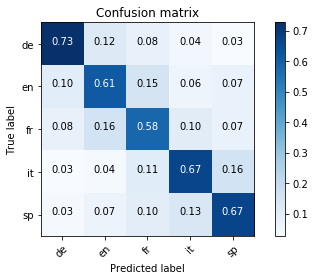

In [42]:
plot_confusion_matrix(cm, languages, normalize=True)

# Embedded features model

In [43]:
data, y_idxs, _ = proc_df(feats, 'language')

In [44]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,23,21,18,4,5,0,0,0,0,0,0,0,0,0,0
1,19,9,3,8,0,0,0,0,0,0,0,0,0,0,0
2,5,9,14,5,0,0,0,0,0,0,0,0,0,0,0
3,1,21,3,8,0,0,0,0,0,0,0,0,0,0,0
4,14,1,3,8,0,0,0,0,0,0,0,0,0,0,0


In [45]:
y_idxs

array([0, 0, 0, ..., 3, 3, 3], dtype=int8)

In [46]:
y_dummy = np.zeros((len(y_idxs), len(languages)))
y_dummy[np.arange(len(y_idxs)), y_idxs] = 1

In [47]:
y_dummy

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

### Model

In [48]:
PATH = 'data/words/'
md = ColumnarModelData.from_data_frame(PATH, val_idxs, df=data, y=y_dummy, cat_flds=list(range(MAX_LEN)), bs=128,
                                       is_reg=False, is_multi=True)

In [49]:
cat_sz = [(c, len(feats[c].cat.categories)+1) for c in list(range(MAX_LEN))]

In [50]:
cat_sz

[(0, 27),
 (1, 27),
 (2, 27),
 (3, 27),
 (4, 27),
 (5, 27),
 (6, 27),
 (7, 27),
 (8, 27),
 (9, 27),
 (10, 27),
 (11, 22),
 (12, 20),
 (13, 18),
 (14, 12)]

In [51]:
emb_szs = [(c, 13) for _, c in cat_sz]

In [52]:
learn = md.get_learner(emb_szs, n_cont=0, emb_drop=0.4, out_sz=len(languages), szs=[500], drops=[0.3])

In [53]:
learn.lr_find()

epoch      trn_loss   val_loss                              
    0      2.285173   5.526195  



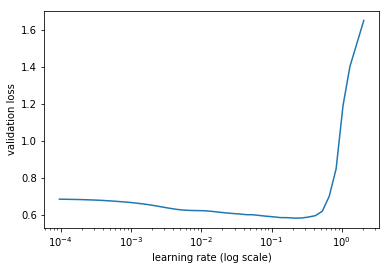

In [54]:
learn.sched.plot()

In [55]:
def accuracy(preds, targs):
    _, preds = torch.max(preds, dim=1)
    _, targs = torch.max(targs, dim=1)
    return (preds==targs).float().mean()

In [56]:
learn.fit(0.01, n_cycle=3, cycle_len=15, cycle_mult=2, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                   
    0      0.614939   0.514464   0.31318   
    1      0.477648   0.395012   0.511592                   
    2      0.414844   0.361492   0.567568                   
    3      0.382383   0.341148   0.603817                   
    4      0.366052   0.335981   0.61637                    
    5      0.348165   0.323477   0.639939                   
    6      0.335591   0.315637   0.646215                   
    7      0.323492   0.308819   0.656334                   
    8      0.313709   0.300381   0.674395                   
    9      0.305449   0.296055   0.678622                   
    10     0.299236   0.295624   0.67875                    
    11     0.292844   0.292552   0.682464                   
    12     0.288487   0.29102    0.684514                   
    13     0.285206   0.290212   0.685667                   
    14     0.28393    0.290226   0.685667                   
    15     0.306571   0.303691   0.659921

[array([0.2775]), 0.7310106314845651]

### Predict and enrich validation dataset for analysis

In [57]:
df_val = df.iloc[val_idxs].reset_index(drop=True)

In [58]:
labels = np.argmax(y_dummy[val_idxs], axis=1)
df_val['language_id'] = labels

In [59]:
preds_dummy = learn.predict_array(x_cat=data.iloc[val_idxs], x_cont=[0])
preds = np.argmax(preds_dummy, axis=1)
probas = np.max(preds_dummy, axis=1)
df_val['pred_id'] = preds
df_val['probas'] = probas

In [60]:
df_val['pred'] = df_val['pred_id'].map(dict(enumerate(languages)))

### Results analysis

In [61]:
# Most confident predictions
df_val.sort_values('probas', ascending=False).head(10)

,word,freq,language,language_id,pred_id,probas,pred
5612,untersuchungen,11,de,0,0,1.0,de
5800,authority,30,en,1,1,1.0,en
2425,zusatzliche,8,de,0,0,1.0,de
2922,historiques,15,fr,2,2,1.0,fr
7611,artillery,12,en,1,1,1.0,en
5132,continuously,5,en,1,1,1.0,en
3361,mythology,5,en,1,1,1.0,en
2927,secretary,9,en,1,1,1.0,en
1777,constituyo,7,sp,4,1,1.0,en
975,fertigstellung,11,de,0,0,1.0,de


In [62]:
# Least confident predictions
df_val.sort_values('probas').head(10)

,word,freq,language,language_id,pred_id,probas,pred
4989,likelihood,5,en,1,4,0.068734,sp
7781,citizenship,7,en,1,4,0.085547,sp
6974,malaysia,13,en,1,4,0.097062,sp
368,construyen,5,sp,4,4,0.109706,sp
5145,apprentissage,6,fr,2,4,0.121741,sp
689,angebot,10,de,0,0,0.148520,de
7557,catawba,5,fr,2,1,0.151246,en
1633,visualizzazione,12,it,3,3,0.159789,it
5059,automobile,5,fr,2,2,0.160266,fr
1125,mythologie,6,fr,2,4,0.163228,sp


In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [64]:
cm = confusion_matrix(df_val['language'], df_val['pred'])

Confusion matrix, without normalization
[[1034  110  105   51   37]
 [ 111 1123  286   93  109]
 [  54  165 1003  169   77]
 [  20   24   92 1417  174]
 [  21   67   99  236 1130]]


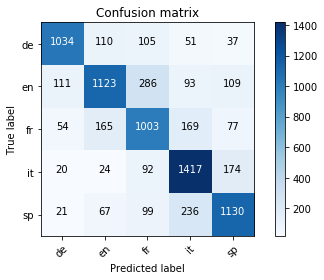

In [65]:
plot_confusion_matrix(cm, languages)

Normalized confusion matrix
[[0.77337 0.08227 0.07853 0.03815 0.02767]
 [0.06446 0.65215 0.16609 0.05401 0.0633 ]
 [0.03678 0.1124  0.68324 0.11512 0.05245]
 [0.01158 0.0139  0.05327 0.8205  0.10075]
 [0.01352 0.04314 0.06375 0.15196 0.72762]]


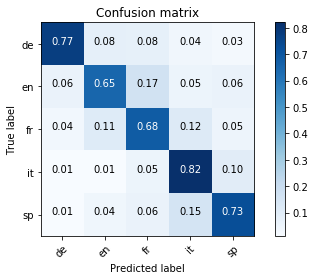

In [66]:
plot_confusion_matrix(cm, languages, normalize=True)